# Linear Regression

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

SEED = 42

## Dataset

In [52]:
df_comb = pd.read_csv("./data/combustion_clean.csv", sep=",")
X_comb = df_comb[['Speed (OBD)(km/h)', 'Absolute Throttle Position B(%)', 'Torque(Nm)']].values
y_comb = df_comb['CO2_emission_g_per_km'].values

In [53]:
n = len(df_comb)
df_elet = pd.read_csv("./data/electric_clean.csv", sep=",")
df_elet_sample = df_elet.sample(n=n, random_state=SEED)
X_elet = df_elet_sample[['Velocity [km/h]', 'Throttle [%]',	'Motor Torque [Nm]']].values
y_elet = df_elet_sample['CO2_emission_g_per_km'].values

In [54]:
X = np.concatenate((X_comb, X_elet), axis=1)
y = np.concatenate((y_comb, y_elet), axis=0)

## Normalização

In [56]:
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

## Treinamento

In [29]:
X_train_comb, X_test_comb, y_train_comb, y_test_comb = train_test_split(X_scaled[:, :3], y_scaled[:n, 0], test_size=0.2, random_state=SEED)
model_comb = LinearRegression(fit_intercept=False)
model_comb.fit(X_train_comb, y_train_comb)

LinearRegression(fit_intercept=False)

In [30]:
X_train_elet, X_test_elet, y_train_elet, y_test_elet = train_test_split(X_scaled[:, 3:], y_scaled[n:, 0], test_size=0.2, random_state=SEED)
model_elet = LinearRegression(fit_intercept=False)
model_elet.fit(X_train_elet, y_train_elet)

LinearRegression(fit_intercept=False)

## Avaliação

In [31]:
def plot_error_histogram(y_pred, y_test):
    # Erro é o predito menos o real
    error = y_pred - y_test

    # Estatísticas do erro
    mean_error = np.mean(error)
    std_error = np.std(error)
    min_error = np.min(error)
    max_error = np.max(error)

    # Histograma
    plt.hist(error, bins=30, color='blue', alpha=0.7, edgecolor='black')

    # Linhas de referência
    plt.axvline(mean_error, color='red', linestyle='dashed', linewidth=2, label=f"Média: {mean_error:.4f}")
    plt.axvline(mean_error + 2*std_error, color='green', linestyle='dashed', linewidth=2, label=f'+2σ: {(mean_error + 2*std_error):.4f}')
    plt.axvline(mean_error - 2*std_error, color='green', linestyle='dashed', linewidth=2, label=f'-2σ: {(mean_error - 2*std_error):.4f}')
    plt.axvline(min_error, color='purple', linestyle='dashed', linewidth=2, label=f'Mínimo: {min_error:.4f}')
    plt.axvline(max_error, color='orange', linestyle='dashed', linewidth=2, label=f'Máximo: {max_error:.4f}')

    # Extras
    plt.xlabel("Erro (y_pred - y_real)")
    plt.ylabel("Frequência")
    plt.legend()
    plt.grid(True)

    plt.show()

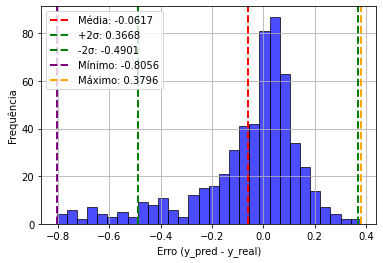

In [35]:
y_pred_comb = model_comb.predict(X_test_comb)
plot_error_histogram(y_pred_comb, y_test_comb)

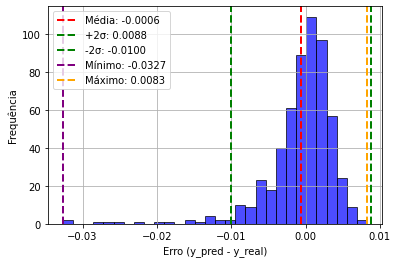

In [37]:
y_pred_elet = model_elet.predict(X_test_elet)
plot_error_histogram(y_pred_elet, y_test_elet)

## Desnormalização

In [44]:
y_concat = np.concatenate(
    (y_test_comb.reshape(len(y_test_comb), 1), y_pred_elet.reshape(len(y_pred_elet), 1)), 
    axis=0
)
result_pred_inv = scaler_y.inverse_transform(y_concat)

In [46]:
y_pred_comb_inv = result_pred_inv[:len(y_test_comb)]
y_pred_elet_inv = result_pred_inv[len(y_test_comb):]

## Avaliação Cruzada

In [48]:
# Ele escreve uma condição aqui que vai utilizar em todas as fórmulas a seguir.
# Nessa condição ele está pegando apenas os casos que a predição foi maior que zero.
# Na real, não podemos ter uma emissão negativa de CO2
valid_idx = (y_pred_comb_inv > 0) & (y_pred_elet_inv > 0)

# Predito da combustão menos o predito do elétrico. Isso seria a predição da redução de emissões
reducao_absoluta = y_pred_comb_inv[valid_idx] - y_pred_elet_inv[valid_idx]

# Calculando o percentual de redução. (Regra de 3)
reducao_percentual = (reducao_absoluta / y_pred_comb_inv[valid_idx]) * 100

# Estatísticas combustão
media_comb = np.mean(y_pred_comb_inv[valid_idx])
mediana_comb = np.median(y_pred_comb_inv[valid_idx])
desvio_comb = np.std(y_pred_comb_inv[valid_idx])
variancia_comb = np.var(y_pred_comb_inv[valid_idx])
min_comb = np.min(y_pred_comb_inv[valid_idx])
max_comb = np.max(y_pred_comb_inv[valid_idx])
cv_comb = desvio_comb / media_comb * 100  # Coeficiente de variação (%)

# Estatísticas elétrico
media_elet = np.mean(y_pred_elet_inv[valid_idx])
mediana_elet = np.median(y_pred_elet_inv[valid_idx])
desvio_elet = np.std(y_pred_elet_inv[valid_idx])
variancia_elet = np.var(y_pred_elet_inv[valid_idx])
min_elet = np.min(y_pred_elet_inv[valid_idx])
max_elet = np.max(y_pred_elet_inv[valid_idx])
cv_elet = desvio_elet / media_elet * 100  # Coeficiente de variação (%)

# Estatísticas para redução absoluta
media_reducao_absoluta = np.mean(reducao_absoluta)
mediana_reducao_absoluta = np.median(reducao_absoluta)
desvio_reducao_absoluta = np.std(reducao_absoluta)
variancia_reducao_absoluta = np.var(reducao_absoluta)
min_reducao_absoluta = np.min(reducao_absoluta)
max_reducao_absoluta = np.max(reducao_absoluta)
cv_reducao_absoluta = desvio_reducao_absoluta / media_reducao_absoluta * 100  

# Estatísticas para redução percentual
media_reducao_percentual = abs(np.mean(reducao_percentual))
mediana_reducao_percentual = abs(np.median(reducao_percentual))
desvio_reducao_percentual = np.std(reducao_percentual)
variancia_reducao_percentual = np.var(reducao_percentual)
min_reducao_percentual = np.min(reducao_percentual)
max_reducao_percentual = np.max(reducao_percentual)
cv_reducao_percentual = desvio_reducao_percentual / media_reducao_percentual * 100

In [49]:
# Exibir os resultados médios
print(f"🚗 Emissão média (Combustão): {media_comb:.2f} g CO2/km")
print(f"   - Mediana: {mediana_comb:.2f} g CO2/km")
print(f"   - Desvio padrão: {desvio_comb:.2f}")
print(f"   - Variância: {variancia_comb:.2f}")
print(f"   - Min: {min_comb:.2f} | Max: {max_comb:.2f}\n")


print(f"⚡ Emissão média (Elétrico): {media_elet:.2f} g CO2/km")
print(f"   - Mediana: {mediana_elet:.2f} g CO2/km")
print(f"   - Desvio padrão: {desvio_elet:.2f}")
print(f"   - Variância: {variancia_elet:.2f}")
print(f"   - Min: {min_elet:.2f} | Max: {max_elet:.2f}\n")


print(f"🔽 Redução média absoluta: {media_reducao_absoluta:.2f} g CO2/km")
print(f"   - Mediana: {mediana_reducao_absoluta:.2f} g CO2/km")
print(f"   - Desvio padrão: {desvio_reducao_absoluta:.2f}")
print(f"   - Variância: {variancia_reducao_absoluta:.2f}")
print(f"   - Min: {min_reducao_absoluta:.2f} | Max: {max_reducao_absoluta:.2f}\n")


print(f"📉 Redução média percentual: {media_reducao_percentual:.2f}%")
print(f"   - Mediana: {mediana_reducao_percentual:.2f}%")
print(f"   - Desvio padrão: {desvio_reducao_percentual:.2f}")
print(f"   - Variância: {variancia_reducao_percentual:.2f}")
print(f"   - Min: {min_reducao_percentual:.2f}% | Max: {max_reducao_percentual:.2f}%\n")

🚗 Emissão média (Combustão): 141.75 g CO2/km
   - Mediana: 132.22 g CO2/km
   - Desvio padrão: 36.47
   - Variância: 1329.86
   - Min: 71.74 | Max: 260.38

⚡ Emissão média (Elétrico): 5.26 g CO2/km
   - Mediana: 4.66 g CO2/km
   - Desvio padrão: 3.34
   - Variância: 11.18
   - Min: 0.10 | Max: 15.16

🔽 Redução média absoluta: 136.49 g CO2/km
   - Mediana: 126.79 g CO2/km
   - Desvio padrão: 36.70
   - Variância: 1346.89
   - Min: 64.13 | Max: 256.74

📉 Redução média percentual: 96.04%
   - Mediana: 96.67%
   - Desvio padrão: 2.79
   - Variância: 7.78
   - Min: 84.73% | Max: 99.94%



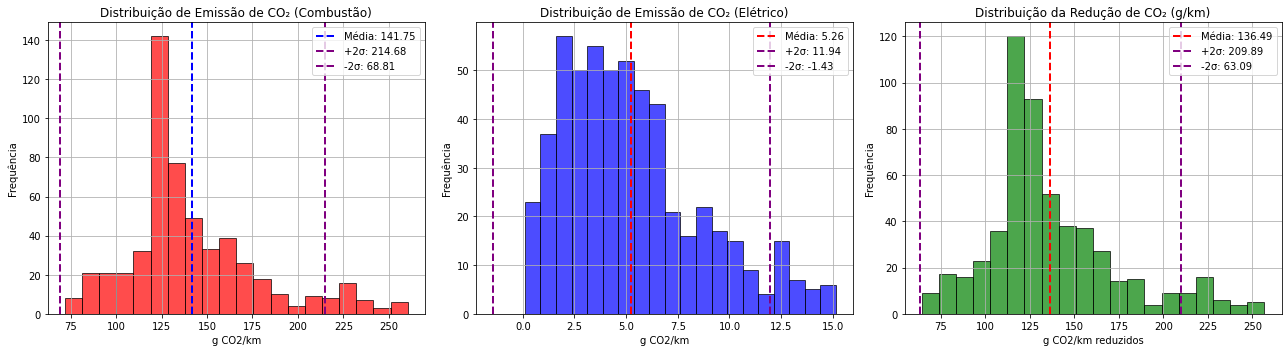

In [50]:
# Previsto para combustão desnormalizado
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
axes[0].hist(y_pred_comb_inv[valid_idx], bins=20, color='red', alpha=0.7, edgecolor='black')
axes[0].axvline(media_comb, color='blue', linestyle='dashed', linewidth=2, label=f'Média: {media_comb:.2f}')
axes[0].axvline(media_comb + 2 * desvio_comb, color='purple', linestyle='dashed', linewidth=2, label=f'+2σ: {(media_comb + 2 * desvio_comb):.2f}')
axes[0].axvline(media_comb - 2 * desvio_comb, color='purple', linestyle='dashed', linewidth=2, label=f'-2σ: {(media_comb - 2 * desvio_comb):.2f}')
axes[0].set_title("Distribuição de Emissão de CO₂ (Combustão)")
axes[0].set_xlabel("g CO2/km")
axes[0].set_ylabel("Frequência")
axes[0].grid()
axes[0].legend()

# Previsto para elétrico desnormalizado
axes[1].hist(y_pred_elet_inv[valid_idx], bins=20, color='blue', alpha=0.7, edgecolor='black')
axes[1].axvline(media_elet, color='red', linestyle='dashed', linewidth=2, label=f'Média: {media_elet:.2f}')
axes[1].axvline(media_elet + 2 * desvio_elet, color='purple', linestyle='dashed', linewidth=2, label=f'+2σ: {(media_elet + 2 * desvio_elet):.2f}')
axes[1].axvline(media_elet - 2 * desvio_elet, color='purple', linestyle='dashed', linewidth=2, label=f'-2σ: {(media_elet - 2 * desvio_elet):.2f}')
axes[1].set_title("Distribuição de Emissão de CO₂ (Elétrico)")
axes[1].set_xlabel("g CO2/km")
axes[1].set_ylabel("Frequência")
axes[1].grid()
axes[1].legend()

# Histograma para redução absoluta
axes[2].hist(reducao_absoluta, bins=20, color='green', alpha=0.7, edgecolor='black')
axes[2].axvline(media_reducao_absoluta, color='red', linestyle='dashed', linewidth=2, label=f'Média: {media_reducao_absoluta:.2f}')
axes[2].axvline(media_reducao_absoluta + 2 * desvio_reducao_absoluta, color='purple', linestyle='dashed', linewidth=2, label=f'+2σ: {(media_reducao_absoluta + 2 * desvio_reducao_absoluta):.2f}')
axes[2].axvline(media_reducao_absoluta - 2 * desvio_reducao_absoluta, color='purple', linestyle='dashed', linewidth=2, label=f'-2σ: {(media_reducao_absoluta - 2 * desvio_reducao_absoluta):.2f}')
axes[2].set_title("Distribuição da Redução de CO₂ (g/km)")
axes[2].set_xlabel("g CO2/km reduzidos")
axes[2].set_ylabel("Frequência")
axes[2].grid()
axes[2].legend()

# Ajustar layout
plt.tight_layout()
plt.show()